Camera index with data_frame starting at 1: 0


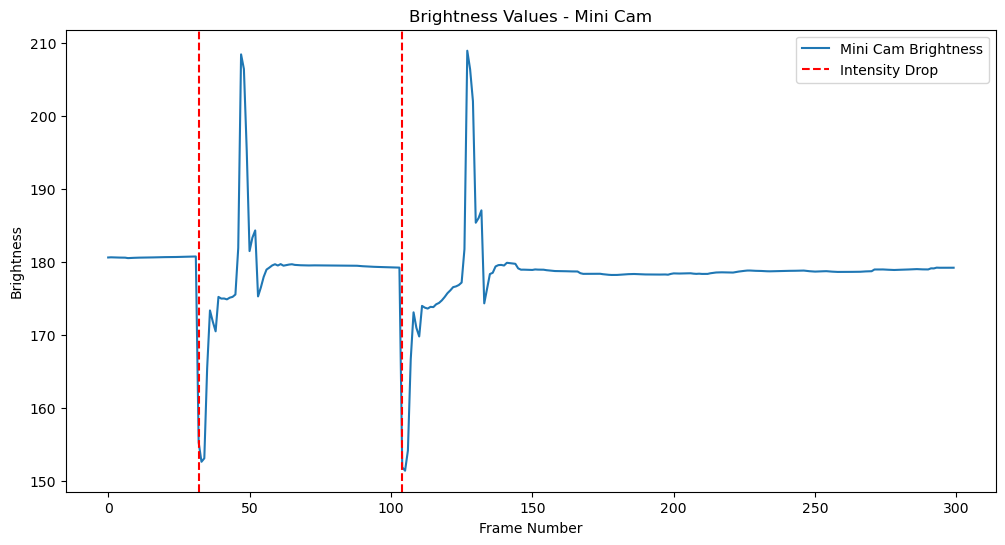

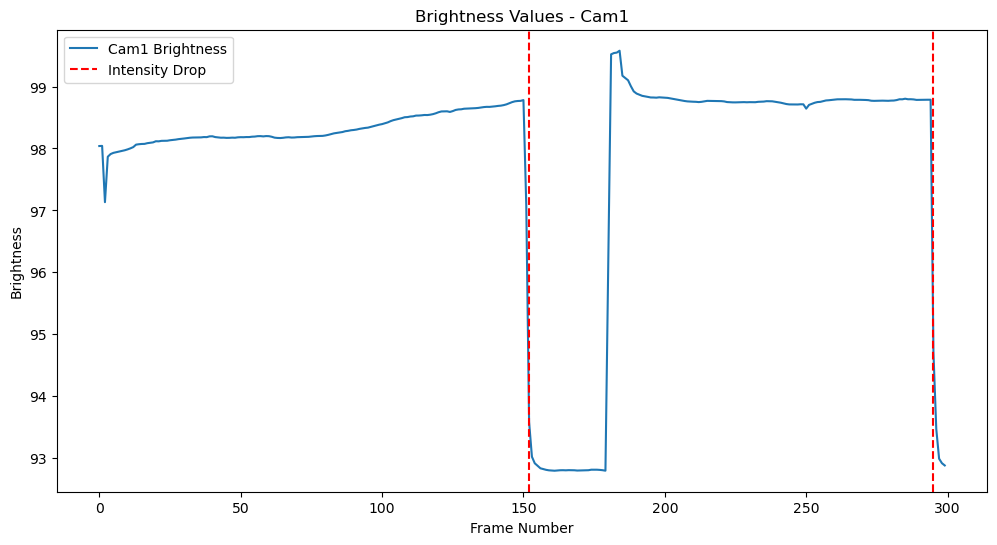

offset:  -2970.2444719998093
Aligned data saved to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35/MIR_Aligned/aligned_data/aligned_predictions.h5
aligned_pred_3d_flat.shape: (8913, 66)
aligned_pred_3d.shape: (8913, 3, 22)
aligned_com.shape: (8913, 3)


In [4]:
import os
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.mini_dannce_sync import sync_videos, align_miniscope_to_sixcam


rec_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35'
mini_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00'
resultsss = sync_videos(
    rec_path,
    mini_path,
    start_frame=0,
    end_frame=300,
    threshold_mini=20,
    threshold_sixcam=3
)

align_miniscope_to_sixcam(resultsss, mini_path, rec_path)


In [ ]:
import pandas as pd

hdf5_input_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35/MIR_Aligned/aligned_data/aligned_predictions.h5'

df = pd.read_hdf(hdf5_input_path, key='df')
mini_cam_timestamps = df.index.values
print("Data loaded successfully!")
# print(df.head())



Data loaded successfully!


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


rec_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35'
mini_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00'

# miniscope data paths
miniscope_path = os.path.join(mini_path, 'My_V4_Miniscope')
miniscope_timestamps_path = os.path.join(miniscope_path, 'timeStamps.csv')

# nc file containing Ca imaging data
nc_files = glob.glob(os.path.join(miniscope_path, '*.nc'))
if not nc_files:
    raise FileNotFoundError("No .nc files found in the specified miniscope path.")
ca_file_path = nc_files[0]

# The Ca data is stored in a .nc file. We'll load it using xarray.
data = xr.open_dataset(ca_file_path)

# The timestamps for Ca data:
timestamps = pd.read_csv(miniscope_timestamps_path)
ts = timestamps['Time Stamp (ms)'].values  # shape (num_ca_frames,)

C = data['C'].values
num_neuron, num_frame = C.shape
print("Calcium data shape:", C.shape)
print("Timestamps shape:", ts.shape)


Calcium data shape: (57, 8951)
Timestamps shape: (8951,)


In [9]:
C_interpolated = []
for i_neuron in range(num_neuron):
    # Create an interpolation function for each neuron
    func = interp1d(ts, C[i_neuron, :], kind='linear', bounds_error=False, fill_value='extrapolate')
    neuron_interp = func(mini_cam_timestamps)
    C_interpolated.append(neuron_interp)

C_interpolated = np.array(C_interpolated)  # shape (num_neuron, N_miniscope_frames)
print("Interpolated Ca data shape:", C_interpolated.shape)

Interpolated Ca data shape: (57, 8913)


In [10]:
# We'll add columns for each neuron, like calcium_roi0, calcium_roi1, etc.
calcium_cols = [f'calcium_roi{i}' for i in range(num_neuron)]

# Transpose C_interpolated to match DataFrame dimensions (N_miniscope_frames, num_neuron)
C_interpolated_transposed = C_interpolated.T  # shape (N_miniscope_frames, num_neuron)

# Create a DataFrame for Ca data
df_ca = pd.DataFrame(data=C_interpolated_transposed, index=mini_cam_timestamps, columns=calcium_cols)
df_ca.index.name = 'timestamp_ms'

# Merge with the existing df
df_merged = df.join(df_ca, how='inner')
print("Data with Ca signals merged:")
print(df_merged.head())

Data with Ca signals merged:
                        com_x       com_y      com_z       kp1_x      kp1_y  \
timestamp_ms_mini                                                             
-56               -112.690879  334.438148  12.985662 -127.787590 -99.152199   
 43               -103.821184  334.773137  12.985662 -108.776749 -86.344803   
 141               -96.245514  339.412280  12.556939  -91.721024 -69.587456   
 254               -80.517925  355.186760  12.476848  -75.779160 -53.046730   
 349               -70.208618  367.197322  12.215108  -68.077621 -42.975372   

                       kp1_z       kp2_x       kp2_y       kp2_z       kp3_x  \
timestamp_ms_mini                                                              
-56               -96.639488 -119.403290 -119.576363 -106.895210  -93.747078   
 43               -78.701828 -105.641449 -114.162590 -109.950737  -99.335510   
 141              -63.158024  -89.005020 -102.038147 -112.997574 -108.470688   
 254             

In [12]:
updated_hdf5_path = os.path.join(rec_path, 'MIR_Aligned', 'aligned_predictions_with_ca.h5')
df_merged.to_hdf(updated_hdf5_path, key='df', mode='w')
print(f"Updated DataFrame with Ca data saved to {updated_hdf5_path}")


Updated DataFrame with Ca data saved to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35/MIR_Aligned/aligned_predictions_with_ca.h5


Correlation between com_x and calcium_roi0: -0.0854977347358581


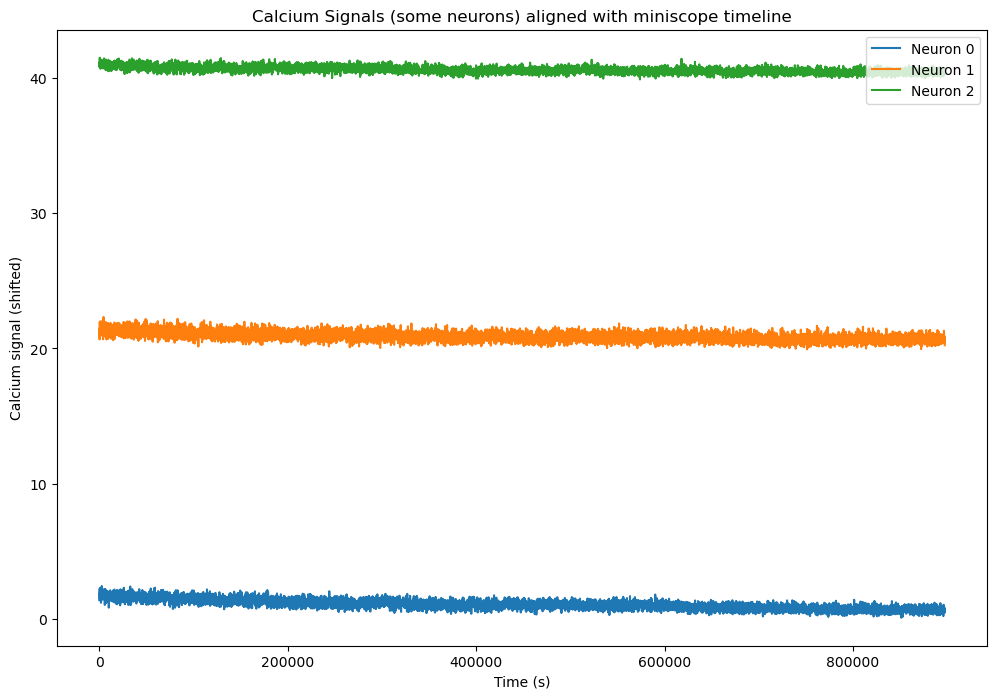

In [13]:

# Check correlation of a calcium ROI with com_x as an example
r = df_merged['com_x'].corr(df_merged['calcium_roi0'])
print("Correlation between com_x and calcium_roi0:", r)

# Plot a few neurons over time
plt.figure(figsize=(12, 8))
selected_neurons = [0, 1, 2]  # first 3 neurons for example
for i, neuron_idx in enumerate(selected_neurons):
    plt.plot(df_merged.index, df_merged[f'calcium_roi{neuron_idx}'] + i*20, label=f'Neuron {neuron_idx}')

plt.xlabel('Time (s)')
plt.ylabel('Calcium signal (shifted)')
plt.title('Calcium Signals (some neurons) aligned with miniscope timeline')
plt.legend()
plt.show()